In [1]:
#Set up environment and import necessary dependencies

%matplotlib inline
from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple;
import numpy as np;

#Make sure the directory is set to import the lab's version of keras
scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)
import keras
print(keras.__path__)

#Import some general util stuff
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

#import deepLIFT stuff
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils

#import deepLIFT stuff
scriptsDir = os.environ.get("DEEPLIFT_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable DEEPLIFT_DIR to point to the deeplift code (WITHIN the deeplift repo)");
sys.path.insert(0,scriptsDir);

import keras_conversion as kc

Using Theano backend.
Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5004)
/users/avanti/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


['/users/avanti/keras/keras']


In [2]:
#Load the keras model, make sure you normalise the weights
#of the first convolutional layer to be mean-centered at each position.
model_weights = "modelsDir_runsDb/record_9_model_CT0YE_modelWeights.h5"
model_yaml = "modelsDir_runsDb/record_9_model_CT0YE_modelYaml.yaml"
reload(kc)
keras_model = kc.load_keras_model(model_weights, model_yaml)
kc.mean_normalise_columns_in_conv_layer(keras_model.nodes["sequentialCore"].layers[0],
                                        normalise_across_rows=True)

In [3]:
keras_model.nodes

OrderedDict([('sequentialCore',
              <keras.layers.containers.Sequential at 0x7f185e262190>),
             ('preOutput-EE_L3',
              <keras.layers.containers.Sequential at 0x7f185e2dad10>),
             ('preOutput-EE_YA',
              <keras.layers.containers.Sequential at 0x7f185e2eda50>),
             ('preOutput-L3_YA',
              <keras.layers.containers.Sequential at 0x7f185e2ec150>),
             ('preOutput-binary',
              <keras.layers.containers.Sequential at 0x7f185e2ec590>)])

In [4]:
#Load the input data. In this example I've adjusted features.yaml to only load the
#positives. The WARNIGNS are expected because the regions from the negatives are
#missing. THere should be 4547 regions in the train,
#437 in the validation and 489 in the test.
from importDataPackage import importData
reload(importData)
trainData, validData, testData = importData.loadTrainTestValidFromYaml("yaml/features.yaml","yaml/labels.yaml", "yaml/splits.yaml")

Processed 100 lines of featuresFile_Seq.fa.out.gz
Processed 200 lines of featuresFile_Seq.fa.out.gz
Processed 300 lines of featuresFile_Seq.fa.out.gz
Processed 400 lines of featuresFile_Seq.fa.out.gz
Processed 500 lines of featuresFile_Seq.fa.out.gz
Processed 600 lines of featuresFile_Seq.fa.out.gz
Processed 700 lines of featuresFile_Seq.fa.out.gz
Processed 800 lines of featuresFile_Seq.fa.out.gz
Processed 900 lines of featuresFile_Seq.fa.out.gz
Processed 1000 lines of featuresFile_Seq.fa.out.gz
Processed 1100 lines of featuresFile_Seq.fa.out.gz
Processed 1200 lines of featuresFile_Seq.fa.out.gz
Processed 1300 lines of featuresFile_Seq.fa.out.gz
Processed 1400 lines of featuresFile_Seq.fa.out.gz
Processed 1500 lines of featuresFile_Seq.fa.out.gz
Processed 1600 lines of featuresFile_Seq.fa.out.gz
Processed 1700 lines of featuresFile_Seq.fa.out.gz
Processed 1800 lines of featuresFile_Seq.fa.out.gz
Processed 1900 lines of featuresFile_Seq.fa.out.gz
Processed 2000 lines of featuresFile_Seq

In [5]:
import keras_conversion as kc
import models
reload(models)
reload(kc)
import blobs
reload(blobs)
from blobs import MxtsMode
deeplift_model = kc.convert_graph_model(keras_model, mxts_mode=MxtsMode.DeepLIFT)

In [6]:
deeplift_model.get_name_to_blob().keys()

['inputMode1',
 'sequentialCore-0',
 'sequentialCore-1',
 'sequentialCore-2',
 'sequentialCore-3',
 'sequentialCore-4',
 'sequentialCore-5',
 'sequentialCore-6',
 'sequentialCore-7',
 'sequentialCore-8',
 'sequentialCore-9',
 'sequentialCore-10',
 'sequentialCore-11',
 'sequentialCore-12',
 'sequentialCore-13',
 'sequentialCore-14',
 'sequentialCore-15',
 'preOutput-EE_L3-0',
 'preOutput-EE_L3-1',
 'preOutput-EE_YA-0',
 'preOutput-EE_YA-1',
 'preOutput-L3_YA-0',
 'preOutput-L3_YA-1',
 'preOutput-binary-0',
 'preOutput-binary-1']

In [7]:
import theano
output_layer_name = 'preOutput-binary-1'
pre_activation_output_layer_name = 'preOutput-binary-0'
data_output_layer_name = 'binary'
idx_of_interest = 2
input_layer_name = 'inputMode1'

In [8]:
#compile a function to get the outputs of that layer
output_func = theano.function([deeplift_model.get_name_to_blob()['inputMode1'].get_activation_vars()],
                              deeplift_model.get_name_to_blob()[output_layer_name].get_activation_vars(),
                              allow_input_downcast=True)

In [9]:
xData = np.concatenate([validData.X[input_layer_name], testData.X[input_layer_name]], axis=0)
xData.shape

(29761, 1, 4, 1000)

In [10]:
yData = np.concatenate([validData.Y[data_output_layer_name], testData.Y[data_output_layer_name]], axis=0)
yData.shape

(29761, 3)

In [11]:
import deeplift_util
outputs = np.array(deeplift_util.run_function_in_batches(func=output_func,
                                                input_data_list=[xData],
                                                progress_update=1000))

Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
Done 14000
Done 15000
Done 16000
Done 17000
Done 18000
Done 19000
Done 20000
Done 21000
Done 22000
Done 23000
Done 24000
Done 25000
Done 26000
Done 27000
Done 28000
Done 29000


In [12]:
#If you set thresholdProb below to something other than 0.5, you
#would also be filtering for true positives whose predicted prob
#was greater than that threshold.
truePositiveIndices=csi.getTruePositiveIndicesAboveThreshold(
                            outputs=outputs[:,idx_of_interest]
                            , trueLabels=yData[:,idx_of_interest]
                            , thresholdProb=0.5)

Deprecated; use deepLIFTutils.getTruePositiveIndicesAboveThreshold
CHECK THAT THIS LOOKS RIGHT!!
Proportion in various quadrants of confusion mat:
(first index is 'true label', second index is 'predicted')
(0, 0, 0.9412055031155531)
(0, 1, 0.05879449688444691)
(1, 0, 0.7163518299881936)
(1, 1, 0.28364817001180637)
('After filtering for true predictions with prob above', 0.5, 'there are', 3844, 'down from', 3844, '(total pos:', 13552, 'of', 29761, ')')


In [13]:
#Run the scoring function on true positives of the full valid+test set
input_layer_deeplift_contribs_func = deeplift_model.get_target_contribs_func(
                                        find_scores_layer_name=input_layer_name,
                                        pre_activation_target_layer_name=pre_activation_output_layer_name)
dLRawContribs_singleNeuron  = np.array(input_layer_deeplift_contribs_func(
                                                        task_idx=idx_of_interest,
                                                        input_data_list=[xData[truePositiveIndices]],
                                                        batch_size=10,
                                                        progress_update=300))
print(dLRawContribs_singleNeuron.shape)

Done 0
Done 300
Done 600
Done 900
Done 1200
Done 1500
Done 1800
Done 2100
Done 2400
Done 2700
Done 3000
Done 3300
Done 3600
(3844, 1, 4, 1000)


In [21]:
reload(csi)
#Prepare the subset of examples you want to compute the grammars on
#Since we previously subset of true positives, this is None
indicesToGetSeqletsOn = None;
#Tip: the initial stage is to compute a distance matrix between the grammars to identify
#clusters. You don't need to compute grammars on all the data for this, so for
#efficiency it may help to consider only a subset of the data.

#The segment identifier determines how a grammar ("segment") is extracted given the critical subset.
#(The segments will later be cross-correlated with each other to compute a confusion matrix, so it
# is preferable to keep them short)
#The algorithm used for the FixedWindowAroundPeaks identifier is as follows:
#   compute sums of the deepLIFT contributions in sliding window of size slidingWindowForMaxSize
#   find peaks (points whose sliding window sums are larger than their neighbours; for plateaus, take the middle)
#   filter out peaks which are not at least ratioToTopPeakToInclude of the tallest peak
#   for each peak in order of highest peak first:
#      add (peakStart-flankToExpandAroundPeakSize
#          , peakStart+slidingWindowForMaxSize+flankToExpandAroundPeakSize)
#      to your list of identified segments
#      filter out any peaks that are within excludePeaksWithinWindow of this peak to your list
#   loop until there are no more candidate peaks left or the total number of segments identified is maxSegments
segmentIdentifier = csi.FixedWindowAroundPeaks(
                        slidingWindowForMaxSize=10
                        , flankToExpandAroundPeakSize=5
                        , excludePeaksWithinWindow=3
                        , ratioToTopPeakToInclude=0.5
                        , maxSegments=5);
#This is now enough to identify the grammars. This function will return an array of
#crticalSubsetIdentification.Grammalr objects as well as an array of the indices
#(corresponding to indicesToGetGrammarOn) that each grammar came from
#(if you pick a segment identifier other than FullSegment, you can have multiple
#grammars per sequence)
seqlets, seqletIndices = csi.getSeqlets(
                                rawDeepLIFTContribs=dLRawContribs_singleNeuron
                                , indicesToGetSeqletsOn=indicesToGetSeqletsOn
                                , outputsBeforeActivation=None #don't worry about this
                                , activation=None #don't worry about this
                                , thresholdProb=1.0 #don't worry about this
                                , segmentIdentifier=segmentIdentifier
                                , numThreads=1
                                , secondsBetweenUpdates=1)

No reverse comp function provided so assuming you have dna as first 4 rows
Done 0 of 3844
Done 100 of 3844
Done 200 of 3844
Done 300 of 3844
Done 400 of 3844
Done 500 of 3844
Done 600 of 3844
Done 700 of 3844
Done 800 of 3844
Done 900 of 3844
Done 1000 of 3844
Done 1100 of 3844
Done 1200 of 3844
Done 1300 of 3844
Done 1400 of 3844
Done 1500 of 3844
Done 1600 of 3844
Done 1700 of 3844
Done 1800 of 3844
Done 1900 of 3844
Done 2000 of 3844
Done 2100 of 3844
Done 2200 of 3844
Done 2300 of 3844
Done 2400 of 3844
Done 2500 of 3844
Done 2600 of 3844
Done 2700 of 3844
Done 2800 of 3844
Done 2900 of 3844
Done 3000 of 3844
Done 3100 of 3844
Done 3200 of 3844
Done 3300 of 3844
Done 3400 of 3844
Done 3500 of 3844
Done 3600 of 3844
Done 3700 of 3844
Done 3800 of 3844


In [22]:
print(len(seqlets))

15176


In [16]:
reload(csi)
print("Computing multipliers")
input_layer_deeplift_multipliers_func = deeplift_model.get_target_multipliers_func(
                                            find_scores_layer_name=input_layer_name,
                                            pre_activation_target_layer_name=pre_activation_output_layer_name)
dLMultipliers_singleNeuron  = np.squeeze(np.array(input_layer_deeplift_multipliers_func(
                                                        task_idx=idx_of_interest,
                                                        input_data_list=[xData[truePositiveIndices]],
                                                        batch_size=10,
                                                        progress_update=100)),axis=1)

Computing multipliers
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Done 1000
Done 1100
Done 1200
Done 1300
Done 1400
Done 1500
Done 1600
Done 1700
Done 1800
Done 1900
Done 2000
Done 2100
Done 2200
Done 2300
Done 2400
Done 2500
Done 2600
Done 2700
Done 2800
Done 2900
Done 3000
Done 3100
Done 3200
Done 3300
Done 3400
Done 3500
Done 3600
Done 3700
Done 3800


In [23]:
#augment tracks with gradient info and underlying sequence info
for dataToAugmentWith,name,pseudocount,revCompFunc in [
                                           (np.squeeze(xData[truePositiveIndices], axis=1)
                                             , "sequence"
                                             , 0.25
                                             , csi.dnaRevCompFunc),
                                           (dLMultipliers_singleNeuron
                                             , "multipliers"
                                             , 0.0
                                             , csi.dnaRevCompFunc)]:
    csi.augmentSeqletsWithData(seqlets, fullDataArr=\
                                        dataToAugmentWith
                                        , keyName=name
                                        , pseudocount=pseudocount
                                        , revCompFunc=revCompFunc
                                        #only provide indicesToSubset if the indices of grammarIndices
                                        #are actually an index into a subset of fullDataArr
                                        #in other words, if you provided an indicesToGetGrammarsOn
                                        #argument above, you probably don't need to provide anything here
                                        #for clarifcation, if provided, the indexes in the grammars 
                                        #will be looked up in indicesToSubset, and the result of THAT
                                        #lookup will be looked up in fullDataArr. If indiciesToGetGrammarsOn
                                        #was provided originally, then the indexes of the grammars will already
                                        #be correct
                                        , indicesToSubset=None)

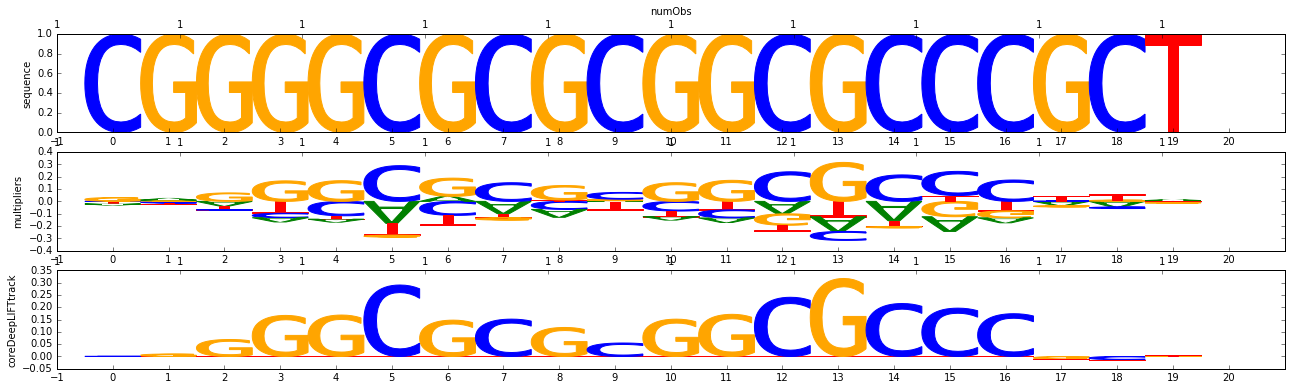

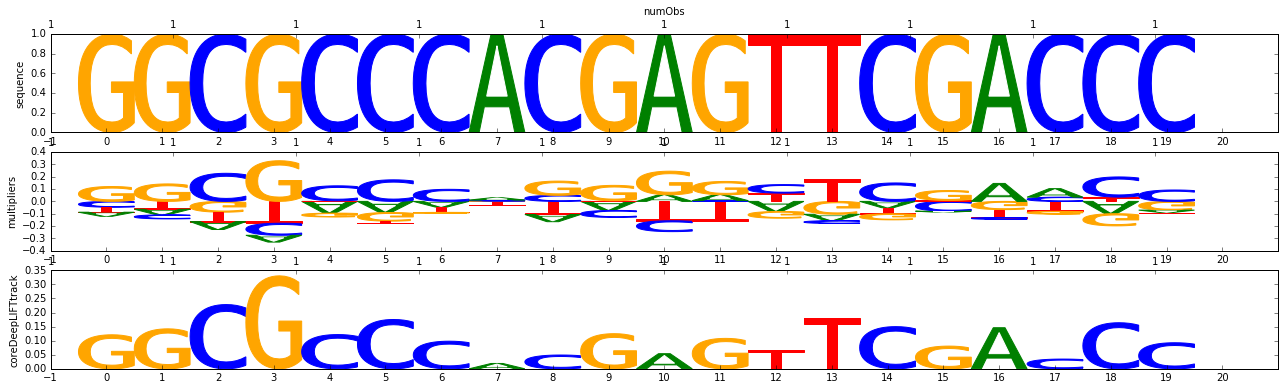

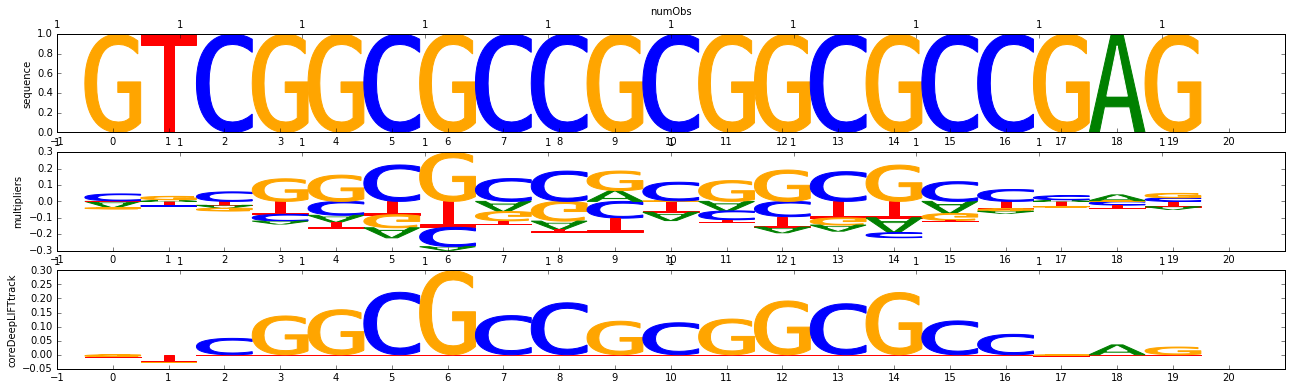

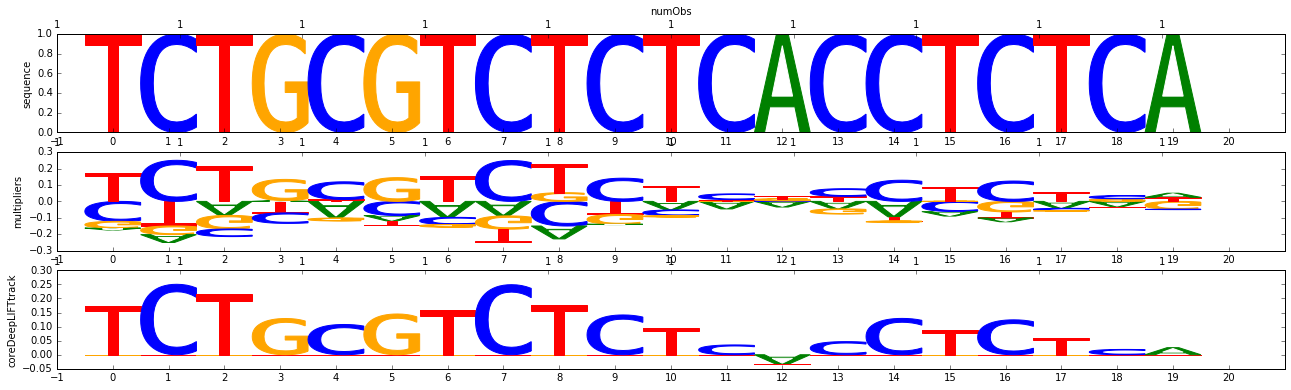

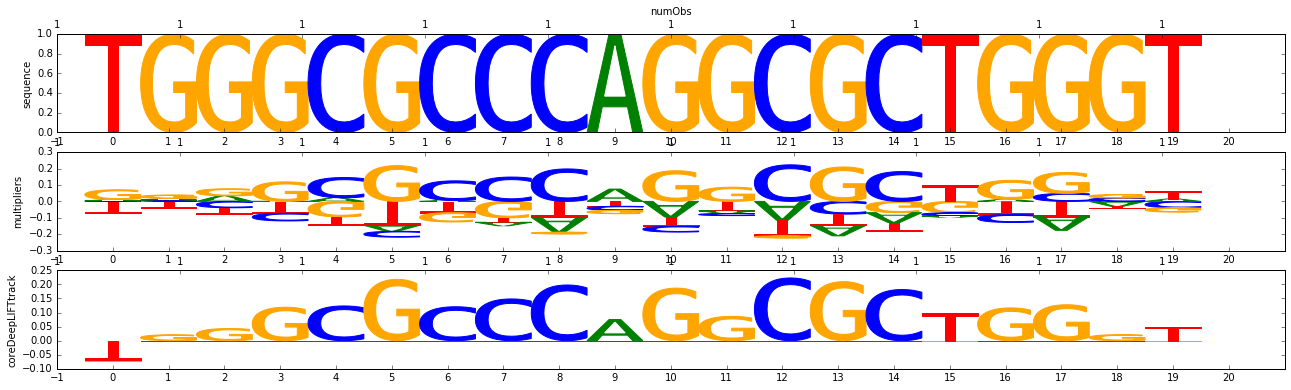

In [24]:
#visually explore the grammars originating from a few examples to get a sense of what they look like
reload(csi)
reload(deepLIFTutils)
trackNamesToPrint=["sequence", "multipliers", csi.coreDeepLIFTtrackName]
for idx in range(5):
    csi.printGrammarWithIdx(seqlets, idx=idx, trackNamesToPrint=trackNamesToPrint, heightPerTrack=2);

17639


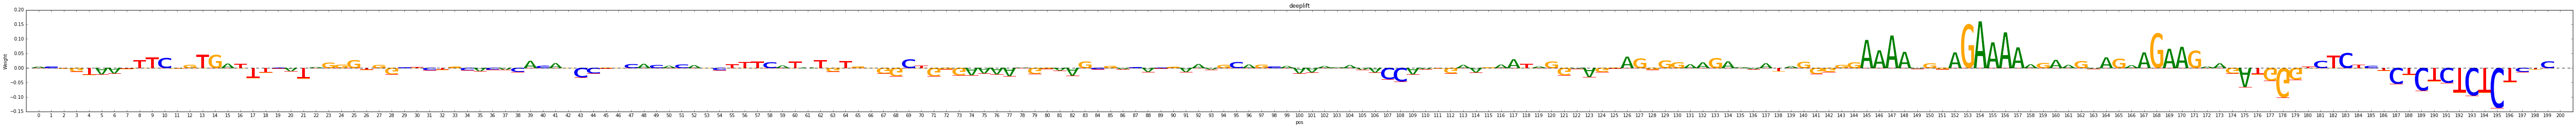

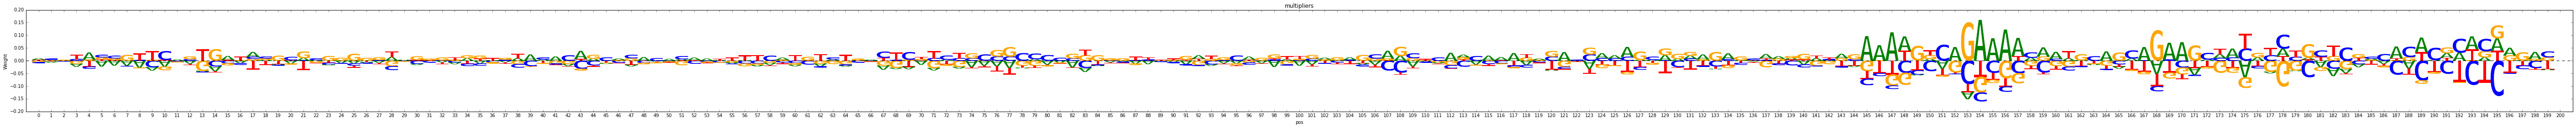

3725


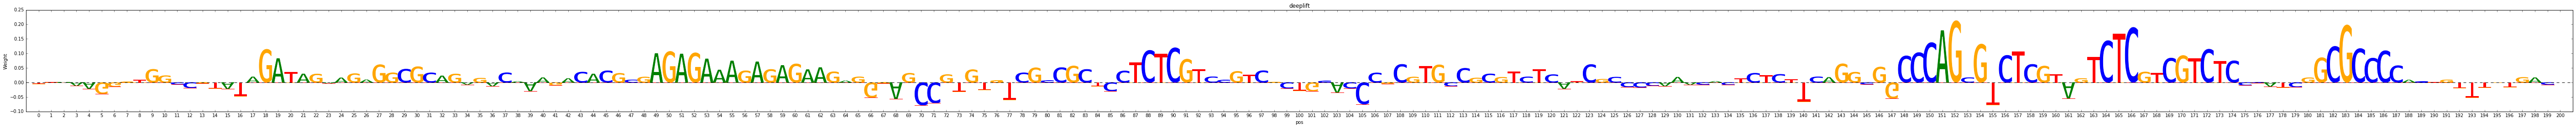

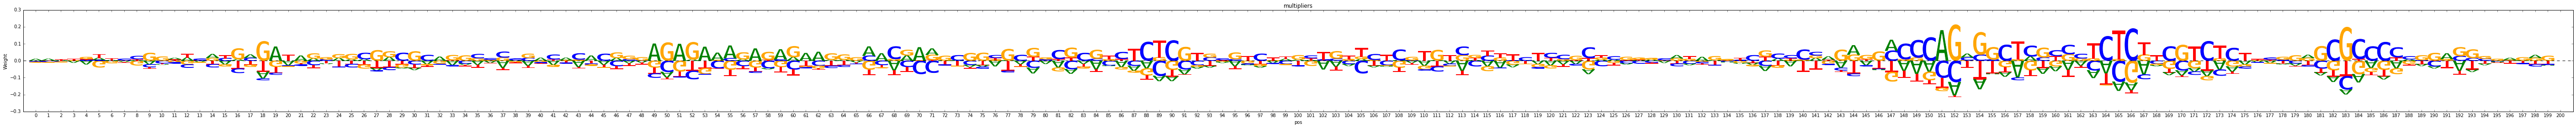

3722


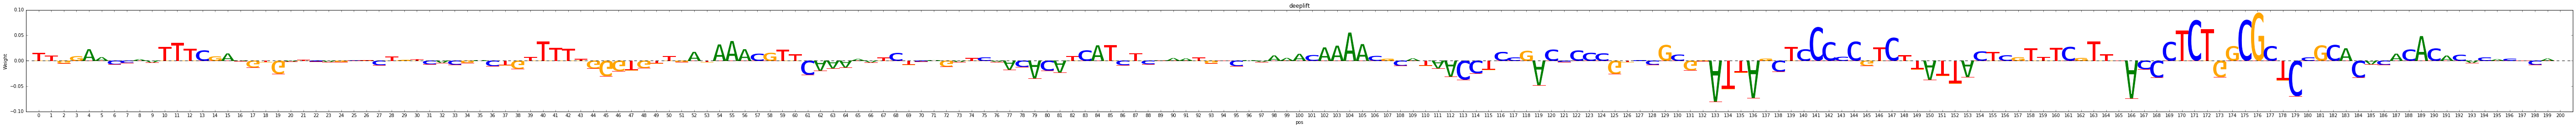

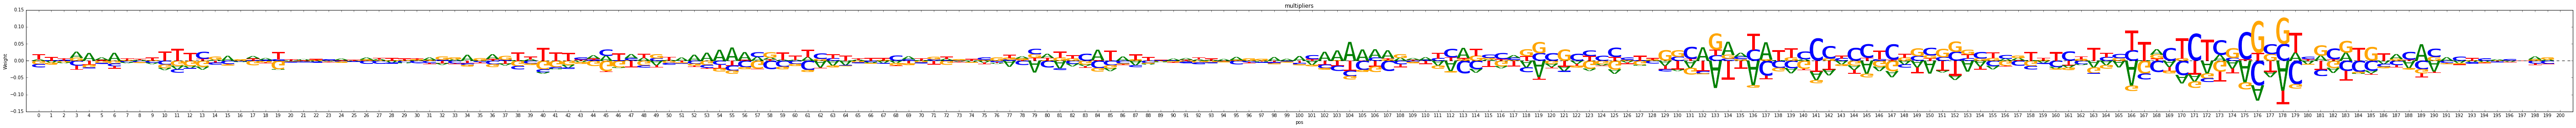

3726


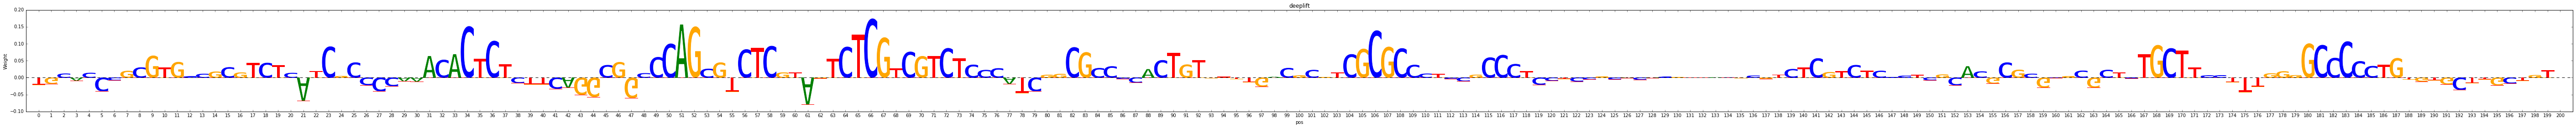

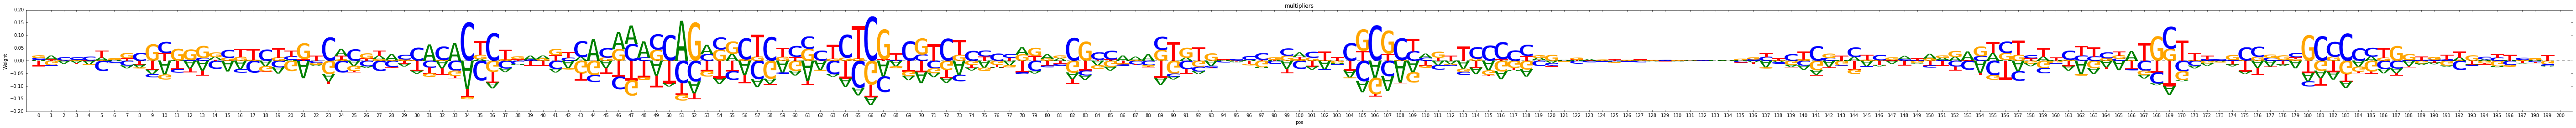

17640


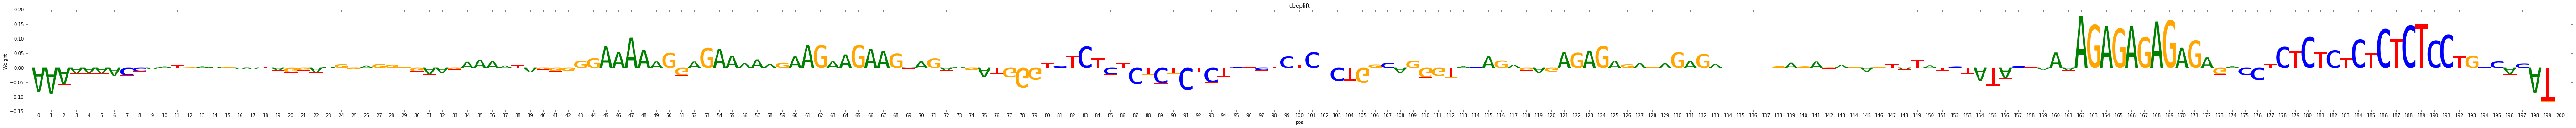

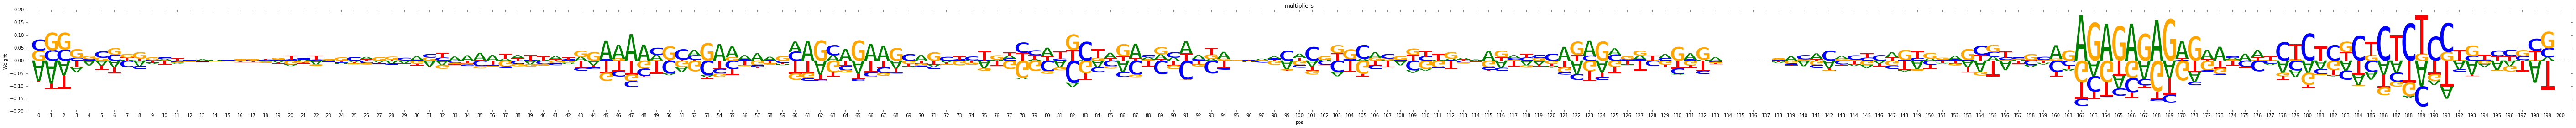

In [19]:
#optional: visualise all the deepLIFT scores that the grammars you visualised
#above originated from (you can find the index into dlValidRawContribs_singleNeuron)
#by looking at the entries of grammarIndices
#WARNING: THIS CAN TAKE A WHILE (like a minute or so depending on the len of the seq)
#It will generate a png but won't attempt to show the png in the notebook becasue the
#png is typically too big to visualise meaningfully

#I am commenting it out because I usually don't want to run it
reload(deepLIFTutils)

sortedOutputs = [x[0] for x in sorted(enumerate(outputs[:,idx_of_interest]), key=lambda x: -x[1])];
truePositiveIndicesMap = dict([(x[1],x[0]) for x in enumerate(truePositiveIndices)])
#idx=469
#idx = data.ids.index("chr1:50717266-50718066")
idxs=[sortedOutputs[i] for i in [0,1,2,3,4]]
for idx in idxs:
    print(idx)
    for scores, scores_name in [(np.squeeze(dLRawContribs_singleNeuron,axis=1), 'deeplift'),
                                (dLMultipliers_singleNeuron, 'multipliers')]:
        deepLIFTutils.plotWeights(scores[truePositiveIndicesMap[idx]].T[300:500],
                                  bias=0, title=scores_name, figSize=(100,4), outputFile=None)
#deepLIFTutils.makePngOfSequenceDeepLIFTScores(dLRawContribs_singleNeuron[idx][:,::-1,::-1]
#                                    , pngName="sequenceDLscores_"+str(idx)+".png"
#                                    , plotConvPath="plotConvFilter.R")

In [25]:
import time;
reload(csi)
reload(util)
#Compute the pairwise distance matrix between the seqlets
#This is by far the most time-consuming operation, so multithread.
#If it takes too long try subsetting to the top 1000 seqlets. Remember for
#this step you don't need all the seqlets, just a representative
#set for clustering.
#On my mac, for 1000 seqlets of len 30bp and 4 threads, this
#took 90 seconds..but it *scales quadratically* so be careful
#grammarsSubset = grammars[:1000]
seqletsSubset=seqlets[:4000]
accountForRevComp=True
#subtracksToInclude represents the set of subtracks to do the
#cross correlation based on. You could in theory do the
#cross correlation based on some of the augmented data tracks
#as well
#subtracksToInclude=[csi.Grammar.coreDeepLIFTtrackName]
subtracksToInclude=["multipliers"]
os.environ['CUDA_DEVICE']="1" #you should set this if you plan to do xcor on the GPU
seqletsCorrMat = csi.getCorrelationMatrix(
                        seqletsSubset
                        , subtracksToInclude=subtracksToInclude
                        , accountForRevComp=accountForRevComp
                        , numThreads=None
                        , secondsBetweenUpdates=3
                        , xcorBatchSize=20 #set this to something other than None to do xcor on GPU
                        #, subtrackNormaliseFunc=util.CROSSC_NORMFUNC.perPositionRange
                        )

Num words: 4000
FFT size 128
FFT time: 0.0279541015625
EWPMK time: 1.52306771278
ifft time: 2.15786457062
MAI time: 84.4435937405
FFT size 128
FFT time: 0.0299069881439
EWPMK time: 1.54148626328
ifft time: 2.1290872097
MAI time: 82.7617206573
Seconds to compute corr mat: 181.917303085


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 1.533553
[t-SNE] Iteration 25: error = 1.8610501, gradient norm = 0.0089943
[t-SNE] Iteration 50: error = 1.7862655, gradient norm = 0.0057107
[t-SNE] Iteration 75: error = 1.5441152, gradient norm = 0.0022719
[t-SNE] Iteration 100: error = 1.4942548, gradient norm = 0.0019255
[t-SNE] Error after 100 iterations with early exaggeration: 1.494255
[t-SNE] Iteration 125: error = 1.4110905, gradient norm = 0.0014919
[t-SNE] Iteration 150: error = 1.3845614, gradient norm = 0.0013875
[t-SNE] Iteration 175: error = 1.3778359, gradient norm = 0.0013633
[t-SNE] Iteration 200: error = 1.3760071, gradient norm = 0.0013567
[t-SNE] Iteration 225: error = 1.3755094, gradient norm

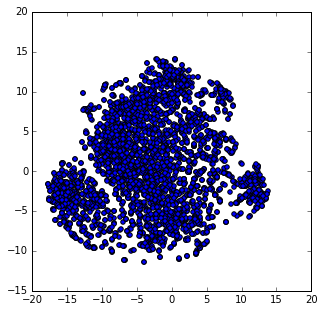

In [26]:
#find the t-sne embedding using the distance metric
reload(csi)
embedding = csi.getTsneEmbeddingOfGrammars(seqletsCorrMat, perplexity=30, verbose=2)
mplh.scatterPlot(embedding)

No colors supplied, so autogen'd as:
(0, [0.0, 1.0, 0.0])
(1, [0.0, 0.0, 1.0])


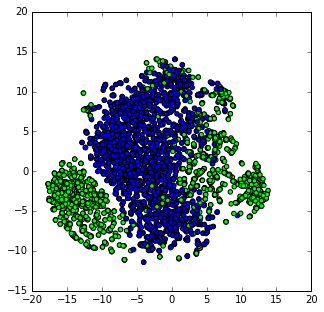

In [27]:
#spectral clustering
#reload(csi)
#reload(util)
#labels=csi.colorTSNEembeddingBySpectralClustering(seqletsCorrMat, embedding, n_clusters=4)

#kmeans clustering
reload(csi)
reload(util)
labels=csi.getKMeansClustering(seqletsCorrMat,n_clusters=2,n_init=10, n_jobs=10);
mplh.scatterPlot(embedding, labels=labels);

In [28]:
reload(csi)
reload(util)
#The trimming function is optional; it is used to further trim uninformative flanks.
#TrimArrayColumnsToPercent trims the grammar to the smallest subsequence that has "percent" importance
#of the original full sequence
#trimmingFunc = csi.TrimArrayColumnsToPercent(percent=0.95)
#TrimArrayColumsnToNumUnderlyingObs resticts attention to those positions in the grammar
#that have at least 20% of the total observations for the grammar supporting them.
trimmingFunc = csi.TrimArrayColumnsToNumUnderlyingObs(0.2)
#once again, subtracksToInclude indicates the subtracks to consider for merging. Should be
#the same as what you supplied for the cross-correlation
mergedGrammars = csi.createMergedGrammars(labels, seqletsSubset
                                          , subtracksToInclude=subtracksToInclude
                                          , accountForRevComp=accountForRevComp)
mergedGrammars = csi.adjustGrammarsUsingTrimmingCriterion(mergedGrammars,trimmingFunc=trimmingFunc);

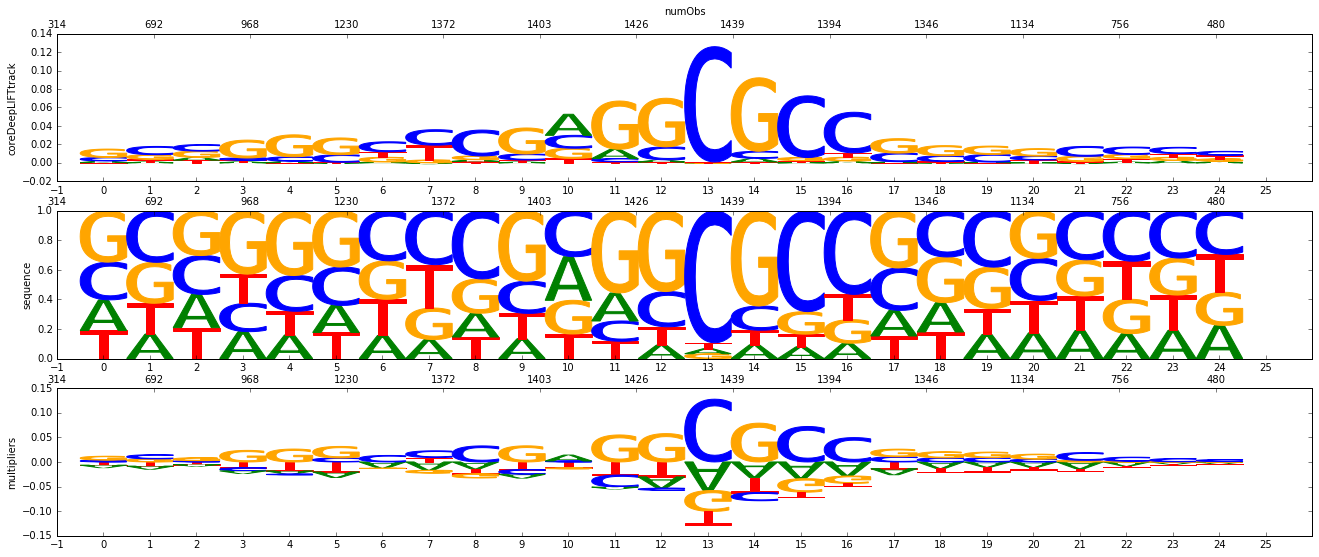

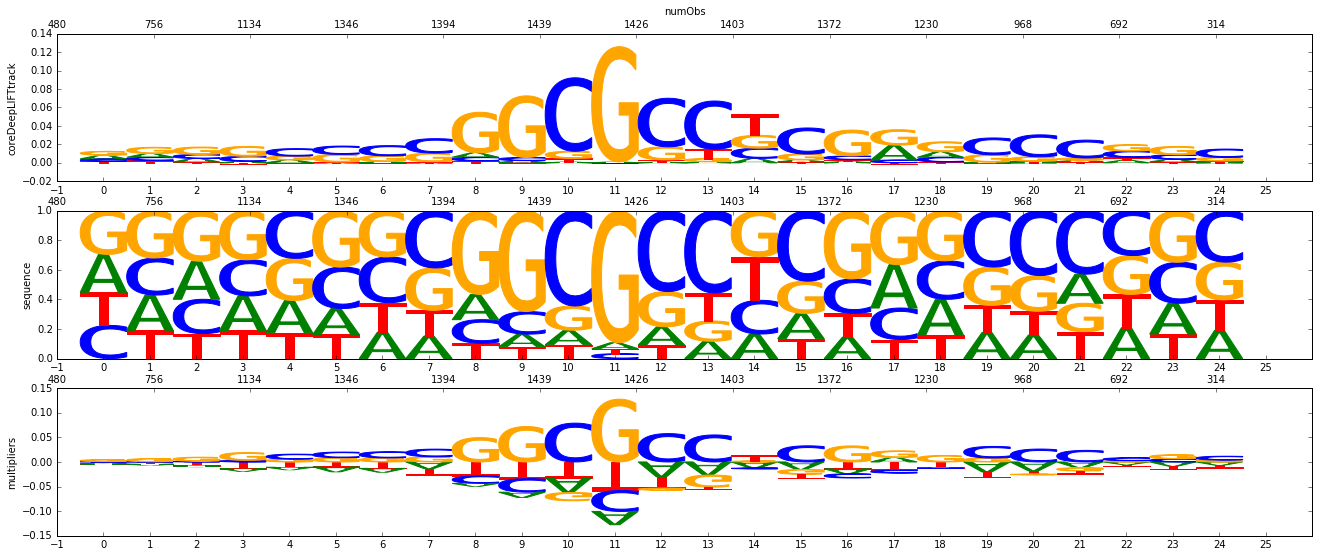

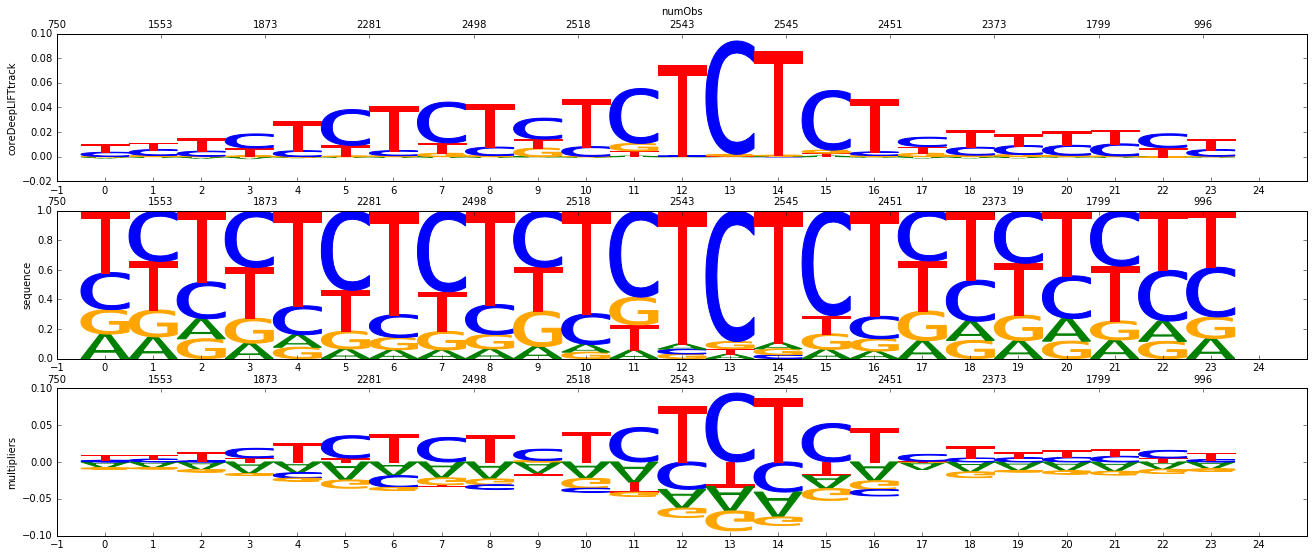

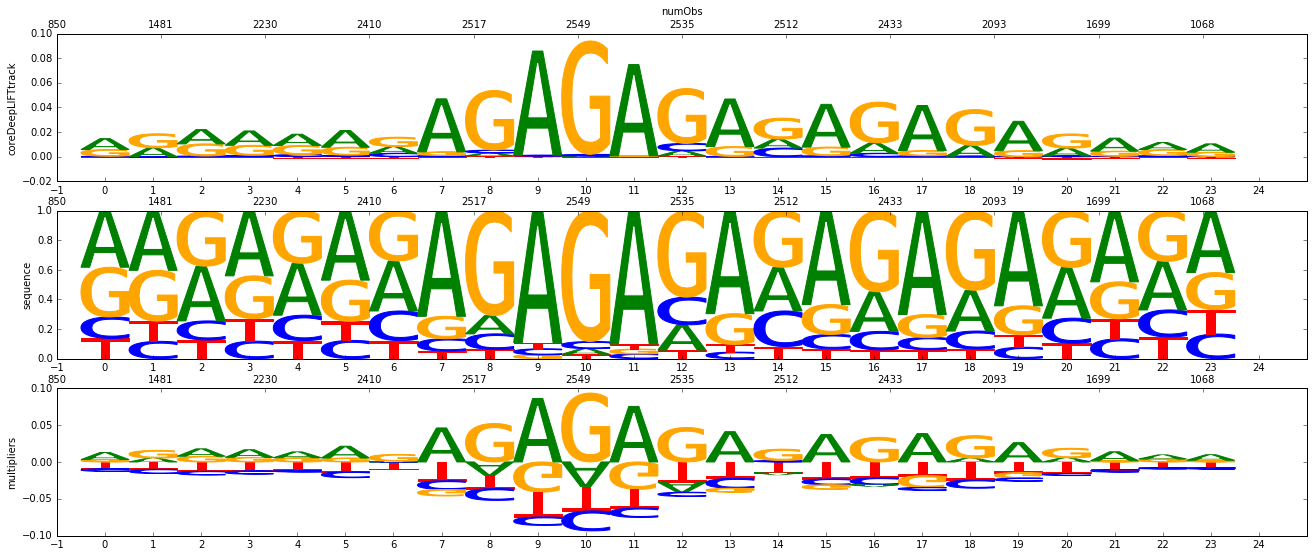

In [29]:
reload(csi)
for grammar in mergedGrammars.values():
    csi.printGrammar(grammar, trackNamesToPrint=[csi.Grammar.coreDeepLIFTtrackName, "sequence",
                                                 "multipliers"])
    csi.printGrammar(grammar.getRevCompGrammar(), trackNamesToPrint=[csi.Grammar.coreDeepLIFTtrackName,
                                                                     "sequence",
                                                                     "multipliers"])